In [1]:
from pandas import Timedelta, to_datetime
from matplotlib.pyplot import subplots, savefig, show, legend, close
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

subset_data: bool = False


def make_biometrics_plots_together_matplotlib(
    data: defaultdict[str, defaultdict[str, defaultdict[str, Series]]],
    user_id: str,
    session_id: str,
    dataset: str,
    experiment_info: DataFrame,
    **kwargs,
) -> None:
    data = {key: val for key, val in data.items() if val is not None}
    fig, axs = subplots(
        len(data.keys()), 1, figsize=(14, 11 * len(data.keys())), sharex=True
    )
    if len(data.keys()) == 1:
        axs = [axs]
    
    for n, (data_type, physiological_data) in tqdm(
        enumerate(data.items()), desc="Plotting data", total=len(data.keys())
    ):
        if physiological_data is None:
            continue

        for side, specific_side_data in physiological_data.items():
            user_data: DataFrame = specific_side_data[user_id]

            if data_type == "EDA":
                eda_type: str = kwargs["eda_type"]
                data_to_plot = user_data[eda_type]
            else:
                data_to_plot = user_data.iloc[:, 0]

            data_to_plot = data_to_plot.loc[IndexSlice[session_id, :]]
            if subset_data:
                data_to_plot = data_to_plot[:1000]

            data_to_plot.index = to_datetime(data_to_plot.index)
            axs[n].plot(
                data_to_plot.index,
                data_to_plot.values,
                label=side,
                linestyle="-",
            )
            axs[n].set_title(data_type)

            # del data_to_plot
            # garbage_collect()

        # session_id_corrected: Timestamp = to_datetime(
        #     session_ids["left"].split("-")[0], format="%y%m%d"
        # )  + Timedelta("1D")
        # session_id_corrected: str = str(session_id_corrected.date())
        if dataset == "mwc2022":
            start_exp = Timestamp(
                experiment_info.loc[IndexSlice[user_id, session_id], "actual_bed_time"]
            )
            end_exp = Timestamp(
                experiment_info.loc[IndexSlice[user_id, session_id], "wake_up_time"]
            )
            # start_exp = start_exp.tz_localize("Europe/Rome")
            # end_exp = end_exp.tz_localize("Europe/Rome")

            axs[n].axvspan(
                xmin=start_exp,
                xmax=end_exp,
                color="#828282",
                alpha=0.3,
                label="sleep time",
            )
            axs[n].set_ylabel(f"Time")
            axs[n].set_ylabel(f"{data_type}")
        elif dataset == "usi_laughs":
            events = set(
                ["_".join(col.split("_")[1:]) for col in experiment_info.columns]
            )
            for i, event in enumerate(events):
                start_exp = Timestamp(experiment_info.loc[user_id, f"start_{event}"])
                end_exp = Timestamp(experiment_info.loc[user_id, f"end_{event}"])
                if "baseline" in event and i == 0:
                    label = "baseline"
                elif "baseline" not in event:
                    label = event
                else:
                    label = None

                axs[n].axvspan(
                    xmin=start_exp,
                    xmax=end_exp,
                    color="#828282" if "baseline" in event else "#548572",
                    alpha=0.3,
                    label=label,
                )
                axs[n].set_ylabel(f"Time")
                axs[n].set_ylabel(f"{data_type}")
        else:
            raise ValueError(
                f"Received as dataset {dataset}, but only mwc2022 and usi_laughs are supported"
            )

    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        fontsize="x-large",
        title="Side",
        title_fontsize="xx-large",
        #    loc='best'
    )
    # legend()
    fig.suptitle(
        f"Plots for all singals for user {user_id}, session {session_id}",
        fontsize=30,
        y=0.97,
    )
    savefig(f"../visualizations/{dataset}_{user_id}_{session_id}.pdf")
    # show()
    close()

    return start_exp, end_exp


# Intro

This notebook is intended to provide data exploration for all datasets concerning this Lateralization study. As the moment, the datasets impemented are:
* USILaughs
* MWC2022 study

I split the same notebook into 2, since I was having problems w/ remote working, due too large filesizes.

# USILaughs

## Cognitive Load Info

In [2]:
from pandas import read_csv, to_datetime
from pandas import IndexSlice, DataFrame
import pandas as pd

pd.options.display.precision = 5

In [3]:
def move_event_to_columns(df):
    starts = {}
    ends = {}
    for event in df.index.get_level_values(1).unique():
        starts[f"start_{event}"] = df.loc[IndexSlice[:, event], "start"].values
        ends[f"end_{event}"] = df.loc[IndexSlice[:, event], "end"].values
    return DataFrame({**starts, **ends})


experiment_info = read_csv(
    "../data.nosync/usilaughs/all_experimento_info.csv", index_col=[0, 1]
)
indexes_to_drop = [
    idx
    for idx in experiment_info.index
    if "baseline" not in idx[1] and "cognitive_load" not in idx[1]
]
experiment_info = experiment_info.drop(indexes_to_drop, inplace=False)
experiment_info = experiment_info.groupby(axis=0, level=0, group_keys=True).apply(
    move_event_to_columns
)
experiment_info.index = experiment_info.index.droplevel(1)


In [4]:
experiment_info = experiment_info.applymap(to_datetime)
experiment_info = experiment_info.applymap(lambda x: x.tz_localize('Europe/Rome'))

## Physiological Data

In [5]:
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

eda_data_base_path: str = "../data.nosync/usilaughs/filtered/*/EDA/*.parquet"
eda_data_paths: list[str] = glob(eda_data_base_path)
eda_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
    lambda: defaultdict()
)
for file in tqdm(eda_data_paths, desc="Loading EDA data"):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    eda_data[side_name][user_name] = read_parquet(file)

bvp_data = None

# bvp_data_base_path: str = "../data/filtered/*/BVP/*.parquet"
# bvp_data_paths: list[str] = glob(bvp_data_base_path)
# bvp_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
#     lambda: defaultdict()
# )
# for file in tqdm(bvp_data_paths, desc="Loading BVP data"):
#     side_name = file.split("/")[-3]
#     user_name = file.split("/")[-1].split(".")[0]
#     bvp_data[side_name][user_name] = read_parquet(file)
    
    
physiological_data: dict[str, defaultdict[str, defaultdict[str, Series]]] = {
    "EDA": eda_data,
    "BVP": bvp_data,
}
del eda_data
del bvp_data
garbage_collect()

Loading EDA data:   0%|          | 0/67 [00:00<?, ?it/s]

252

After inspection, user 40 has to be removed, since his experiment time and the timestamps from the E4 do not match.

In [6]:
experiment_info = experiment_info.drop('s040', axis=0, inplace=False)
del physiological_data['EDA']['left']['s040']
del physiological_data['EDA']['right']['s040']
# del physiological_data['BVP']['left']['s040']
# del physiological_data['BVP']['right']['s040']

In [7]:
users_left = physiological_data["EDA"]["left"].keys()
users_right = physiological_data["EDA"]["right"].keys()
users = list(set(users_left) & set(users_right))
sessions_all = ['experiment']

In [8]:
# session = session_selection.value
for user in tqdm(sorted(users), desc='Plotting user data', colour='red'):
    for session in sessions_all:
        make_biometrics_plots_together_matplotlib(
            data=physiological_data,
            user_id=user,
            session_id=session,
            dataset='usi_laughs',
            experiment_info=experiment_info,
            eda_type="mixed-EDA",
        )


Plotting user data:   0%|          | 0/32 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
users_in_left_side = set(physiological_data['EDA']['left'].keys())
users_in_right_side = set(physiological_data['EDA']['right'].keys())

In [9]:
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 32


## Segmentation

The segmentation will be performed over `baseline_1` and `cognitive_load` periods. Other baselines are not considered, since they were very short periods performed after some activity, one of which was cognitive load itself. As such, brian phenomena from those activites might propagate in the EDA signal and make the classification harded.

In [10]:
experiment_info_as_dict: dict[str, Series] = {
    participant: experiment_info.loc[participant, :]
    for participant in list(experiment_info.index.unique())
}

In [11]:
segment_size_in_secs = 4
eda_sample_rate = 4
segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate

In [12]:
eda_data = physiological_data['EDA']

In [13]:
# user = "U13"
# info = experiment_info_as_dict[user]
# data = eda_data['left'][user]

In [14]:
from numpy import nan, ndarray
from pandas import Timedelta


def get_session_moment(start: Timestamp, end: Timestamp, info: Series) -> int | float:
    # TODO: check that this is working as expected
    # this method gives 0 if the person is awake and 1 if the person is
    if (end < info["end_baseline_1"]) or (
        (start < info["end_baseline_1"] and end > info["end_baseline_1"])
    ):
        return 0
    elif (start > info["end_baseline_1"] and end < info["start_cognitive_load"]) or (
        start > info["end_cognitive_load"]) or (
            start < info["start_cognitive_load"] and end > info["start_cognitive_load"]
        ):
        return nan
    else:
        return 1


data_segmented_left: list[tuple] = []
data_segmented_right: list[tuple] = []
users = list(set(eda_data["left"].keys()) & set(eda_data["right"].keys()))

for user in tqdm(users, desc='User progress', colour='blue'):
    data_left = eda_data["left"][user]
    data_right = eda_data["right"][user]
    info = experiment_info_as_dict[user]
    
    # FIXME: using sessions like this seems stupid, but allows to reuse code
    # from the other experiment. I should however find a way around it
    sessions_all = ['experiment']
    for session in sessions_all:
        session_data_left: DataFrame = data_left.loc[IndexSlice[session, :], :]
        session_data_right: DataFrame = data_right.loc[IndexSlice[session, :], :]

        session_info = info

        starts_left = session_data_left[
            ::segment_size_in_sampling_rate
        ].index.get_level_values(1)
        starts_right = session_data_right[
            ::segment_size_in_sampling_rate
        ].index.get_level_values(1)

        ends_left = (
            session_data_left[::segment_size_in_sampling_rate].index.get_level_values(1)
            + Timedelta(f"{segment_size_in_secs}s")
            - Timedelta(f"{1/eda_sample_rate}s")
        )
        ends_right = (
            session_data_right[::segment_size_in_sampling_rate].index.get_level_values(
                1
            )
            + Timedelta(f"{segment_size_in_secs}s")
            - Timedelta(f"{1/eda_sample_rate}s")
        )

        segments_left = [
            (
                session_data_left.loc[
                    IndexSlice[session, start:end],
                    "mixed-EDA",
                ].values,
                get_session_moment(start, end, session_info),
                user,
            )
            for start, end in zip(starts_left, ends_left)
        ]
        segments_right = [
            (
                session_data_right.loc[
                    IndexSlice[session, start:end],
                    "mixed-EDA",
                ].values,
                get_session_moment(start, end, session_info),
                user,
            )
            for start, end in zip(starts_right, ends_right)
        ]
        data_segmented_left.append(segments_left)
        data_segmented_right.append(segments_right)


User progress:   0%|          | 0/32 [00:00<?, ?it/s]

In [15]:
from numpy import isnan
values_left = [
    val[0]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]
values_right = [
    val[0]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

labels_left = [
    val[1]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]
labels_right = [
    val[1]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

groups_left = [
    val[2]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]

groups_right = [
    val[2]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

0    480
1    384
dtype: int64
0    55.55556
1    44.44444
dtype: float64


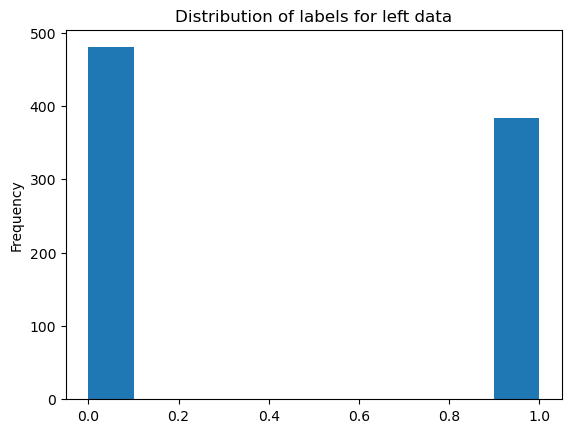

In [16]:
import matplotlib.pyplot as plt

Series(labels_left).plot(kind="hist")
plt.title('Distribution of labels for left data')
print(Series(labels_left).value_counts())
print(Series(labels_left).value_counts()/Series(labels_left).count()*100)

0    480
1    384
dtype: int64
0    55.55556
1    44.44444
dtype: float64


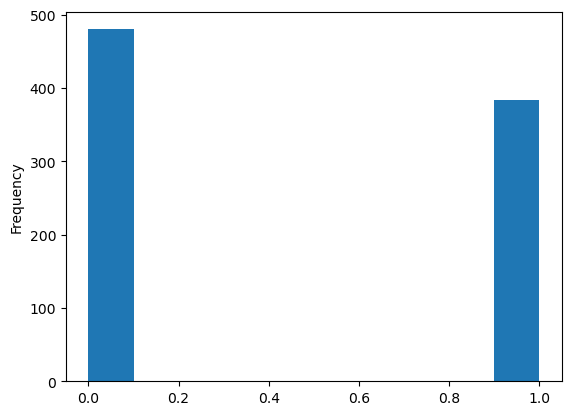

In [17]:
Series(labels_right).plot(kind="hist")
print(Series(labels_right).value_counts())
print(Series(labels_right).value_counts()/Series(labels_right).count()*100)

The distribution is almost balanced: as such, re-balancing should not be a large problem.

## Feature Extraction

In [18]:
from sys import path
path.append("../")
from joblib import Parallel, delayed
from src.feature_extraction.eda import get_eda_features
from numpy import stack

features_left = Parallel(n_jobs=-1)(delayed(get_eda_features)(value) for value in (values_left))
features_right = Parallel(n_jobs=-1)(delayed(get_eda_features)(value) for value in (values_right))

features_left: ndarray = stack(features_left)
features_right: ndarray = stack(features_right)

labels_left: ndarray = stack(labels_left)
labels_right: ndarray = stack(labels_right)

groups_left: ndarray = stack(groups_left)
groups_right: ndarray = stack(groups_right)

Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Coul

In [19]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")

features_left.shape=(864, 11)
labels_left.shape=(864,)
groups_left.shape=(864,)


## ML Prediction

### 5-fold CV

#### LX v LX

In [88]:
from sklearn.model_selection import KFold
from imblearn.under_sampling import (
    RandomUnderSampler,
    ClusterCentroids,
    NearMiss,
    TomekLinks,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    CondensedNearestNeighbour,
    OneSidedSelection,
    NeighbourhoodCleaningRule,
    InstanceHardnessThreshold,
)
from lazypredict.Supervised import LazyClassifier
import pandas as pd

x, y = features_left, labels_left
cc = RandomUnderSampler(random_state=42)
x_resampled, y_resampled = cc.fit_resample(x, y)

folds = KFold(n_splits=5, random_state=42, shuffle=True).split(x_resampled, y_resampled)
all_models = []
for train_index, test_index in tqdm(folds, desc="Folds progress:", total=5):
    x_train, x_test = x_resampled[train_index], x_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    clf = LazyClassifier(predictions=True)
    models, predictions = clf.fit(x_train, x_test, y_train, y_test)
    all_models.append(models)


averages = (
    pd.concat(all_models)
    .groupby(level=0)
    .mean()
    .sort_values(by="Accuracy", ascending=False)
)
standard_deviations = (
    pd.concat(all_models)
    .groupby(level=0)
    .std()
    .sort_values(by="Accuracy", ascending=False)
)
standard_errors = standard_deviations / 5**0.5


Folds progress::   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 19.63it/s]


In [62]:
pd.concat([averages, standard_errors], axis=1, keys=["Average", "Standard error"])

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
BaggingClassifier                 0.77              0.77    0.77     0.77   
RandomForestClassifier            0.76              0.76    0.76     0.76   
ExtraTreesClassifier              0.75              0.75    0.75     0.75   
XGBClassifier                     0.74              0.74    0.74     0.74   
LGBMClassifier                    0.74              0.74    0.74     0.74   
AdaBoostClassifier                0.71              0.71    0.71     0.71   
LabelSpreading                    0.71              0.71    0.71     0.71   
LabelPropagation                  0.71              0.71    0.71     0.71   
KNeighborsClassifier              0.70              0.71    0.71     0.70   
DecisionTreeClassifier            0.70              0.70    0.70     0.70   
NuSVC                             0.70              0.70    0.70     0.70   
SVC                               0.69              0.69    0.69     0.69   
ExtraTreeClassifier               0.68              0.68    0.68     0.68   
BernoulliNB                       0.65              0.64    0.64     0.64   
LinearSVC                         0.64              0.64    0.64     0.64   
LogisticRegression                0.64              0.64    0.64     0.64   
CalibratedClassifierCV            0.63              0.63    0.63     0.63   
RidgeClassifierCV                 0.63              0.63    0.63     0.63   
RidgeClassifier                   0.63              0.63    0.63     0.63   
LinearDiscriminantAnalysis        0.63              0.63    0.63     0.63   
NearestCentroid                   0.62              0.62    0.62     0.62   
SGDClassifier                     0.60              0.60    0.60     0.57   
PassiveAggressiveClassifier       0.59              0.60    0.60     0.55   
Perceptron                        0.57              0.57    0.57     0.53   
GaussianNB                        0.55              0.55    0.55     0.48   
QuadraticDiscriminantAnalysis     0.55              0.54    0.54     0.48   
DummyClassifier                   0.47              0.50    0.50     0.30   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
BaggingClassifier                   0.03           0.01              0.01   
RandomForestClassifier              0.16           0.01              0.01   
ExtraTreesClassifier                0.12           0.02              0.02   
XGBClassifier                       0.38           0.01              0.01   
LGBMClassifier                      0.35           0.02              0.02   
AdaBoostClassifier                  0.08           0.02              0.02   
LabelSpreading                      0.02           0.03              0.03   
LabelPropagation                    0.02           0.02              0.02   
KNeighborsClassifier                0.01           0.02              0.02   
DecisionTreeClassifier              0.01           0.03              0.03   
NuSVC                               0.02           0.02              0.02   
SVC                                 0.02           0.02              0.02   
ExtraTreeClassifier                 0.01           0.01              0.01   
BernoulliNB                         0.01           0.01              0.02   
LinearSVC                           0.03           0.01              0.01   
LogisticRegression                  0.01           0.01              0.01   
CalibratedClassifierCV              0.12           0.01              0.02   
RidgeClassifierCV                   0.01           0.01              0.01   
RidgeClassifier                     0.01           0.01              0.01   
LinearDiscriminantAnalysis

#### RX vs RX

In [63]:
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
from lazypredict.Supervised import LazyClassifier
import pandas as pd

x, y = features_right, labels_right
cc = RandomUnderSampler(random_state=42)
x_resampled, y_resampled = cc.fit_resample(x, y)

folds = KFold(n_splits=5, random_state=42, shuffle=True).split(x_resampled, y_resampled)
all_models = []
for train_index, test_index in tqdm(folds, desc="Folds progress:", total=5):
    x_train, x_test = x_resampled[train_index], x_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    clf = LazyClassifier(predictions=True)
    models, predictions = clf.fit(x_train, x_test, y_train, y_test)
    all_models.append(models)
    


averages = pd.concat(all_models).groupby(level=0).mean().sort_values(by="Accuracy", ascending=False)
standard_deviations = pd.concat(all_models).groupby(level=0).std().sort_values(by="Accuracy", ascending=False)
standard_errors = standard_deviations/5**0.5

Folds progress::   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 19.86it/s]


In [64]:
pd.concat([averages, standard_errors], axis=1, keys=["Average", "Standard error"])

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier            0.81              0.81    0.81     0.81   
LGBMClassifier                    0.81              0.81    0.81     0.81   
BaggingClassifier                 0.81              0.81    0.81     0.81   
ExtraTreesClassifier              0.80              0.80    0.80     0.80   
XGBClassifier                     0.80              0.80    0.80     0.80   
AdaBoostClassifier                0.78              0.78    0.78     0.78   
KNeighborsClassifier              0.77              0.77    0.77     0.77   
NuSVC                             0.77              0.77    0.77     0.77   
SVC                               0.77              0.77    0.77     0.77   
ExtraTreeClassifier               0.76              0.76    0.76     0.76   
LabelSpreading                    0.75              0.75    0.75     0.75   
LabelPropagation                  0.75              0.75    0.75     0.75   
DecisionTreeClassifier            0.74              0.74    0.74     0.74   
RidgeClassifierCV                 0.70              0.70    0.70     0.70   
BernoulliNB                       0.69              0.69    0.69     0.69   
LinearDiscriminantAnalysis        0.69              0.69    0.69     0.69   
GaussianNB                        0.69              0.69    0.69     0.69   
RidgeClassifier                   0.69              0.69    0.69     0.69   
NearestCentroid                   0.69              0.69    0.69     0.69   
LinearSVC                         0.69              0.69    0.69     0.69   
LogisticRegression                0.69              0.68    0.68     0.69   
CalibratedClassifierCV            0.69              0.68    0.68     0.69   
SGDClassifier                     0.64              0.65    0.65     0.62   
Perceptron                        0.63              0.62    0.62     0.62   
PassiveAggressiveClassifier       0.60              0.59    0.59     0.58   
QuadraticDiscriminantAnalysis     0.58              0.59    0.59     0.54   
DummyClassifier                   0.47              0.50    0.50     0.30   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier              0.16           0.01              0.01   
LGBMClassifier                      0.34           0.01              0.01   
BaggingClassifier                   0.03           0.01              0.01   
ExtraTreesClassifier                0.12           0.01              0.01   
XGBClassifier                       0.39           0.02              0.02   
AdaBoostClassifier                  0.08           0.02              0.02   
KNeighborsClassifier                0.01           0.01              0.01   
NuSVC                               0.02           0.01              0.01   
SVC                                 0.02           0.01              0.01   
ExtraTreeClassifier                 0.01           0.02              0.02   
LabelSpreading                      0.02           0.01              0.01   
LabelPropagation                    0.02           0.01              0.01   
DecisionTreeClassifier              0.01           0.00              0.00   
RidgeClassifierCV                   0.01           0.01              0.01   
BernoulliNB                         0.01           0.01              0.01   
LinearDiscriminantAnalysis          0.01           0.01              0.01   
GaussianNB                          0.01           0.03              0.02   
RidgeClassifier                     0.01           0.01              0.01   
NearestCentroid                     0.01           0.01              0.01   
LinearSVC                 

#### LX vs RX

In [69]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(predictions=True, random_state=42)
x_resampled_lx, y_resampled_lx = cc.fit_resample(features_left, labels_left)
x_resampled_rx, y_resampled_rx = cc.fit_resample(features_right, labels_right)
models, predictions = clf.fit(x_resampled_lx, x_resampled_rx, y_resampled_lx, y_resampled_rx)

100%|██████████| 29/29 [00:01<00:00, 14.66it/s]


In [70]:
models.sort_values(by="Balanced Accuracy", ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
KNeighborsClassifier,0.76,0.76,0.76,0.76,0.02
RandomForestClassifier,0.75,0.75,0.75,0.75,0.19
ExtraTreesClassifier,0.75,0.75,0.75,0.75,0.14
SVC,0.75,0.75,0.75,0.75,0.04
LabelSpreading,0.74,0.74,0.74,0.74,0.02
AdaBoostClassifier,0.74,0.74,0.74,0.74,0.10
NuSVC,0.73,0.73,0.73,0.73,0.05
LabelPropagation,0.73,0.73,0.73,0.73,0.03
BaggingClassifier,0.73,0.73,0.73,0.73,0.04


#### RX vs LX

In [77]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(predictions=True, random_state=42)
x_resampled_lx, y_resampled_lx = cc.fit_resample(features_left, labels_left)
x_resampled_rx, y_resampled_rx = cc.fit_resample(features_right, labels_right)
models, predictions = clf.fit(x_resampled_rx, x_resampled_lx, y_resampled_rx, y_resampled_lx)

100%|██████████| 29/29 [00:01<00:00, 16.08it/s]


In [78]:
models.sort_values(by="Balanced Accuracy", ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.70,0.70,0.70,0.70,0.14
KNeighborsClassifier,0.70,0.70,0.70,0.70,0.02
RandomForestClassifier,0.70,0.70,0.70,0.70,0.18
SVC,0.70,0.70,0.70,0.70,0.04
BaggingClassifier,0.70,0.70,0.70,0.70,0.04
LGBMClassifier,0.69,0.69,0.69,0.69,0.42
LabelSpreading,0.69,0.69,0.69,0.69,0.04
LabelPropagation,0.69,0.69,0.69,0.69,0.04
XGBClassifier,0.69,0.69,0.69,0.69,0.43


#### Test with different seeds (LX vs LX)

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [22]:
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import (
    RandomUnderSampler,
    ClusterCentroids,
    NearMiss,
    TomekLinks,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    CondensedNearestNeighbour,
    OneSidedSelection,
    NeighbourhoodCleaningRule,
    InstanceHardnessThreshold,
)
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed

x, y = features_left, labels_left
cc = RandomUnderSampler(random_state=42)
x_resampled, y_resampled = cc.fit_resample(x, y)

results = []
# NOTE: we still set a single seed, from which we generate a bunch of other
# random seeds to be fed to the algorithm
set_numpy_seed(42)
n_seeds_to_test_classifiers: int = 10
random_states_classifiers = randint(0, int(2**32 - 1), n_seeds_to_test_classifiers)

set_numpy_seed(666)
n_seeds_to_test_folds: int = 10
random_states_folds = randint(0, int(2**32 - 1), n_seeds_to_test_folds)

for random_state_folds in tqdm(random_states_folds, desc="Random states folds progress:", colour="blue"):
    for random_state_classifier in tqdm(random_states_classifiers, desc="Random states classifiers progress:", colour="green"):
        # NOTE: the fold generation should be fixed, to limit the accuracy
        # be due exclusively to starting confitions in the algorithm
        folds = StratifiedKFold(n_splits=5, random_state=random_state_folds, shuffle=True).split(
            x_resampled, y_resampled
        )
        # TODO: we should iterate over different random states for the fold
        # generation as well, but independent from the random seeds for the algorithm
        all_models = []
        for train_index, test_index in folds:
            x_train, x_test = x_resampled[train_index], x_resampled[test_index]
            y_train, y_test = y_resampled[train_index], y_resampled[test_index]
            clf = LazyClassifier(predictions=True, random_state=random_state_classifier)
            models, predictions = clf.fit(x_train, x_test, y_train, y_test)
            all_models.append(models)

        averages = (
            pd.concat(all_models)
            .groupby(level=0)
            .mean()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_deviations = (
            pd.concat(all_models)
            .groupby(level=0)
            .std()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_errors = standard_deviations / 5**0.5
        results.append(
            pd.concat(
                [averages, standard_errors], axis=1, keys=["Average", "Standard error"]
            )
        )

averages_seeds = (
    pd.concat(results)
    .groupby(level=0)
    .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
    .droplevel(axis=1, level=0)
    .sort_values(by=("Accuracy"), ascending=False)
)

errors_seeds = (
    pd.concat(results)
    .groupby(level=0)
    .apply(
        lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
        / (n_seeds_to_test_classifiers * n_seeds_to_test_folds)
    )
    .droplevel(axis=1, level=0)
    .sort_values(by="Accuracy", ascending=False)
)


Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 22.37it/s]





100%|██████████| 29/29 [00:01<00:00, 23.35it/s]





100%|██████████| 29/29 [00:01<00:00, 22.49it/s]





100%|██████████| 29/29 [00:01<00:00, 22.81it/s]





100%|██████████| 29/29 [00:01<00:00, 23.52it/s]





100%|██████████| 29/29 [00:01<00:00, 23.84it/s]





100%|██████████| 29/29 [00:01<00:00, 23.17it/s]





100%|██████████| 29/29 [00:01<00:00, 24.02it/s]





100%|██████████| 29/29 [00:01<00:00, 23.46it/s]





100%|██████████| 29/29 [00:01<00:00, 23.37it/s]





100%|██████████| 29/29 [00:01<00:00, 23.37it/s]





100%|██████████| 29/29 [00:01<00:00, 22.43it/s]





100%|██████████| 29/29 [00:01<00:00, 24.46it/s]





100%|██████████| 29/29 [00:01<00:00, 23.32it/s]





100%|██████████| 29/29 [00:01<00:00, 22.93it/s]





100%|██████████| 29/29 [00:01<00:00, 23.54it/s]





100%|██████████| 29/29 [00:01<00:00, 23.31it/s]





100%|██████████| 29/29 [00:01<00:00, 23.92it/s]





100%|██████████| 29/29 [00:01<00:00, 22.4

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 23.50it/s]





100%|██████████| 29/29 [00:01<00:00, 23.69it/s]





100%|██████████| 29/29 [00:01<00:00, 23.47it/s]





100%|██████████| 29/29 [00:01<00:00, 23.10it/s]





100%|██████████| 29/29 [00:01<00:00, 23.14it/s]





100%|██████████| 29/29 [00:01<00:00, 23.87it/s]





100%|██████████| 29/29 [00:01<00:00, 23.44it/s]





100%|██████████| 29/29 [00:01<00:00, 23.52it/s]





100%|██████████| 29/29 [00:01<00:00, 23.97it/s]





100%|██████████| 29/29 [00:01<00:00, 22.93it/s]





100%|██████████| 29/29 [00:01<00:00, 23.81it/s]





100%|██████████| 29/29 [00:01<00:00, 23.68it/s]





100%|██████████| 29/29 [00:01<00:00, 23.44it/s]





100%|██████████| 29/29 [00:01<00:00, 22.40it/s]





100%|██████████| 29/29 [00:01<00:00, 23.02it/s]





100%|██████████| 29/29 [00:01<00:00, 24.09it/s]





100%|██████████| 29/29 [00:01<00:00, 23.47it/s]





100%|██████████| 29/29 [00:01<00:00, 24.08it/s]






100%|██████████| 29/29 [00:01<00:00, 22.

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:02<00:00, 13.22it/s]





100%|██████████| 29/29 [00:01<00:00, 19.13it/s]





100%|██████████| 29/29 [00:01<00:00, 18.45it/s]






100%|██████████| 29/29 [00:01<00:00, 18.19it/s]





100%|██████████| 29/29 [00:01<00:00, 20.64it/s]





100%|██████████| 29/29 [00:01<00:00, 18.75it/s]





100%|██████████| 29/29 [00:01<00:00, 19.46it/s]





100%|██████████| 29/29 [00:03<00:00,  7.72it/s]





100%|██████████| 29/29 [00:02<00:00, 11.75it/s]





100%|██████████| 29/29 [00:02<00:00, 13.86it/s]





100%|██████████| 29/29 [00:01<00:00, 17.06it/s]





100%|██████████| 29/29 [00:01<00:00, 19.22it/s]





100%|██████████| 29/29 [00:01<00:00, 18.80it/s]





100%|██████████| 29/29 [00:01<00:00, 18.20it/s]





100%|██████████| 29/29 [00:01<00:00, 20.18it/s]





100%|██████████| 29/29 [00:01<00:00, 23.36it/s]





100%|██████████| 29/29 [00:01<00:00, 23.83it/s]





100%|██████████| 29/29 [00:01<00:00, 23.40it/s]





100%|██████████| 29/29 [00:01<00:00, 23.

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:15<00:00,  1.90it/s]







100%|██████████| 29/29 [00:27<00:00,  1.06it/s]





100%|██████████| 29/29 [00:02<00:00, 12.19it/s]








100%|██████████| 29/29 [00:13<00:00,  2.09it/s]





100%|██████████| 29/29 [00:01<00:00, 18.99it/s]





100%|██████████| 29/29 [00:01<00:00, 18.81it/s]





100%|██████████| 29/29 [00:01<00:00, 19.65it/s]





100%|██████████| 29/29 [00:01<00:00, 18.36it/s]





100%|██████████| 29/29 [00:01<00:00, 18.33it/s]





100%|██████████| 29/29 [00:01<00:00, 19.59it/s]





100%|██████████| 29/29 [00:01<00:00, 19.42it/s]





100%|██████████| 29/29 [00:01<00:00, 19.73it/s]





100%|██████████| 29/29 [00:01<00:00, 19.02it/s]





100%|██████████| 29/29 [00:01<00:00, 18.78it/s]





100%|██████████| 29/29 [00:01<00:00, 17.78it/s]





100%|██████████| 29/29 [00:02<00:00, 11.70it/s]





100%|██████████| 29/29 [00:01<00:00, 18.40it/s]





100%|██████████| 29/29 [00:01<00:00, 20.46it/s]





100%|██████████| 29/29 [00:01<00:00,

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 18.21it/s]





100%|██████████| 29/29 [00:02<00:00, 11.90it/s]





100%|██████████| 29/29 [00:01<00:00, 18.57it/s]





100%|██████████| 29/29 [00:01<00:00, 19.48it/s]





100%|██████████| 29/29 [00:01<00:00, 19.92it/s]





100%|██████████| 29/29 [00:01<00:00, 16.03it/s]





100%|██████████| 29/29 [00:01<00:00, 18.02it/s]





100%|██████████| 29/29 [00:01<00:00, 19.48it/s]





100%|██████████| 29/29 [00:01<00:00, 19.02it/s]





100%|██████████| 29/29 [00:01<00:00, 15.10it/s]





100%|██████████| 29/29 [00:01<00:00, 18.95it/s]





100%|██████████| 29/29 [00:01<00:00, 20.09it/s]





100%|██████████| 29/29 [00:01<00:00, 18.98it/s]





100%|██████████| 29/29 [00:01<00:00, 19.16it/s]





100%|██████████| 29/29 [00:01<00:00, 19.73it/s]





100%|██████████| 29/29 [00:01<00:00, 19.00it/s]





100%|██████████| 29/29 [00:01<00:00, 20.71it/s]





100%|██████████| 29/29 [00:01<00:00, 19.37it/s]





100%|██████████| 29/29 [00:01<00:00, 18.2

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 23.09it/s]





100%|██████████| 29/29 [00:01<00:00, 23.60it/s]





100%|██████████| 29/29 [00:01<00:00, 23.88it/s]





100%|██████████| 29/29 [00:01<00:00, 23.64it/s]





100%|██████████| 29/29 [00:01<00:00, 23.19it/s]





100%|██████████| 29/29 [00:01<00:00, 23.21it/s]





100%|██████████| 29/29 [00:01<00:00, 22.93it/s]





100%|██████████| 29/29 [00:01<00:00, 23.78it/s]





100%|██████████| 29/29 [00:01<00:00, 23.40it/s]





100%|██████████| 29/29 [00:01<00:00, 23.12it/s]





100%|██████████| 29/29 [00:01<00:00, 23.30it/s]





100%|██████████| 29/29 [00:01<00:00, 22.40it/s]





100%|██████████| 29/29 [00:01<00:00, 24.24it/s]





100%|██████████| 29/29 [00:01<00:00, 23.85it/s]





100%|██████████| 29/29 [00:01<00:00, 23.57it/s]





100%|██████████| 29/29 [00:01<00:00, 23.35it/s]





100%|██████████| 29/29 [00:01<00:00, 23.11it/s]





100%|██████████| 29/29 [00:01<00:00, 23.21it/s]





100%|██████████| 29/29 [00:01<00:00, 23.6

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 23.33it/s]





100%|██████████| 29/29 [00:01<00:00, 23.75it/s]





100%|██████████| 29/29 [00:01<00:00, 23.58it/s]





100%|██████████| 29/29 [00:01<00:00, 23.21it/s]





100%|██████████| 29/29 [00:01<00:00, 23.55it/s]





100%|██████████| 29/29 [00:01<00:00, 23.60it/s]





100%|██████████| 29/29 [00:01<00:00, 23.39it/s]





100%|██████████| 29/29 [00:01<00:00, 23.65it/s]





100%|██████████| 29/29 [00:01<00:00, 22.65it/s]





100%|██████████| 29/29 [00:01<00:00, 23.82it/s]





100%|██████████| 29/29 [00:01<00:00, 23.31it/s]





100%|██████████| 29/29 [00:01<00:00, 23.06it/s]





100%|██████████| 29/29 [00:01<00:00, 22.54it/s]





100%|██████████| 29/29 [00:01<00:00, 23.98it/s]





100%|██████████| 29/29 [00:01<00:00, 23.74it/s]





100%|██████████| 29/29 [00:01<00:00, 23.55it/s]





100%|██████████| 29/29 [00:01<00:00, 23.65it/s]





100%|██████████| 29/29 [00:01<00:00, 22.59it/s]





100%|██████████| 29/29 [00:01<00:00, 24.1

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 23.26it/s]





100%|██████████| 29/29 [00:01<00:00, 22.74it/s]





100%|██████████| 29/29 [00:01<00:00, 24.01it/s]






100%|██████████| 29/29 [00:01<00:00, 23.05it/s]





100%|██████████| 29/29 [00:01<00:00, 24.43it/s]





100%|██████████| 29/29 [00:01<00:00, 23.14it/s]





100%|██████████| 29/29 [00:01<00:00, 23.75it/s]





100%|██████████| 29/29 [00:01<00:00, 24.09it/s]





100%|██████████| 29/29 [00:01<00:00, 23.43it/s]





100%|██████████| 29/29 [00:01<00:00, 22.73it/s]





100%|██████████| 29/29 [00:01<00:00, 22.94it/s]





100%|██████████| 29/29 [00:01<00:00, 23.87it/s]





100%|██████████| 29/29 [00:01<00:00, 23.56it/s]





100%|██████████| 29/29 [00:01<00:00, 23.24it/s]





100%|██████████| 29/29 [00:01<00:00, 23.44it/s]





100%|██████████| 29/29 [00:01<00:00, 23.24it/s]





100%|██████████| 29/29 [00:01<00:00, 23.83it/s]





100%|██████████| 29/29 [00:01<00:00, 22.67it/s]





100%|██████████| 29/29 [00:01<00:00, 23.

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 23.30it/s]





100%|██████████| 29/29 [00:01<00:00, 23.84it/s]





100%|██████████| 29/29 [00:01<00:00, 23.82it/s]





100%|██████████| 29/29 [00:01<00:00, 23.66it/s]





100%|██████████| 29/29 [00:01<00:00, 23.43it/s]





100%|██████████| 29/29 [00:01<00:00, 23.37it/s]





100%|██████████| 29/29 [00:01<00:00, 22.34it/s]





100%|██████████| 29/29 [00:01<00:00, 23.59it/s]





100%|██████████| 29/29 [00:01<00:00, 23.39it/s]





100%|██████████| 29/29 [00:01<00:00, 23.30it/s]





100%|██████████| 29/29 [00:01<00:00, 23.12it/s]





100%|██████████| 29/29 [00:01<00:00, 23.65it/s]





100%|██████████| 29/29 [00:01<00:00, 23.91it/s]





100%|██████████| 29/29 [00:01<00:00, 23.51it/s]





100%|██████████| 29/29 [00:01<00:00, 23.23it/s]





100%|██████████| 29/29 [00:01<00:00, 23.61it/s]





100%|██████████| 29/29 [00:01<00:00, 23.17it/s]





100%|██████████| 29/29 [00:01<00:00, 23.29it/s]





100%|██████████| 29/29 [00:01<00:00, 23.2

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 29/29 [00:01<00:00, 22.94it/s]





100%|██████████| 29/29 [00:01<00:00, 24.34it/s]





100%|██████████| 29/29 [00:01<00:00, 23.49it/s]





100%|██████████| 29/29 [00:01<00:00, 23.66it/s]





100%|██████████| 29/29 [00:01<00:00, 23.51it/s]





100%|██████████| 29/29 [00:01<00:00, 23.42it/s]





100%|██████████| 29/29 [00:01<00:00, 23.13it/s]





100%|██████████| 29/29 [00:01<00:00, 23.39it/s]





100%|██████████| 29/29 [00:01<00:00, 23.84it/s]





100%|██████████| 29/29 [00:01<00:00, 23.49it/s]





100%|██████████| 29/29 [00:01<00:00, 23.81it/s]





100%|██████████| 29/29 [00:01<00:00, 23.83it/s]





100%|██████████| 29/29 [00:01<00:00, 23.17it/s]





100%|██████████| 29/29 [00:01<00:00, 23.28it/s]





100%|██████████| 29/29 [00:01<00:00, 22.91it/s]





100%|██████████| 29/29 [00:01<00:00, 23.51it/s]





100%|██████████| 29/29 [00:01<00:00, 23.50it/s]





100%|██████████| 29/29 [00:01<00:00, 23.92it/s]





100%|██████████| 29/29 [00:01<00:00, 23.9

In [23]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(pd.concat([averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"]))

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.7704            0.7703  0.7703   0.7699   
RandomForestClassifier          0.7666            0.7666  0.7666   0.7660   
LGBMClassifier                  0.7511            0.7511  0.7511   0.7506   
XGBClassifier                   0.7502            0.7501  0.7501   0.7498   
BaggingClassifier               0.7431            0.7431  0.7431   0.7427   
LabelPropagation                0.7244            0.7243  0.7243   0.7238   
LabelSpreading                  0.7236            0.7236  0.7236   0.7231   
NuSVC                           0.7146            0.7146  0.7146   0.7135   
KNeighborsClassifier            0.7141            0.7141  0.7141   0.7135   
AdaBoostClassifier              0.7079            0.7079  0.7079   0.7072   
DecisionTreeClassifier          0.7069            0.7069  0.7069   0.7063   
SVC                             0.6990            0.6990  0.6990   0.6984   
ExtraTreeClassifier             0.6927            0.6927  0.6927   0.6921   
LogisticRegression              0.6354            0.6355  0.6355   0.6347   
LinearSVC                       0.6316            0.6316  0.6316   0.6308   
CalibratedClassifierCV          0.6304            0.6304  0.6304   0.6295   
RidgeClassifier                 0.6291            0.6291  0.6291   0.6283   
RidgeClassifierCV               0.6285            0.6286  0.6286   0.6278   
LinearDiscriminantAnalysis      0.6262            0.6262  0.6262   0.6254   
NearestCentroid                 0.6245            0.6245  0.6245   0.6239   
BernoulliNB                     0.6188            0.6188  0.6188   0.6171   
SGDClassifier                   0.5730            0.5731  0.5731   0.5593   
Perceptron                      0.5553            0.5553  0.5553   0.5385   
PassiveAggressiveClassifier     0.5494            0.5494  0.5494   0.5214   
GaussianNB                      0.5473            0.5473  0.5473   0.4675   
QuadraticDiscriminantAnalysis   0.5400            0.5400  0.5400   0.4807   
DummyClassifier                 0.4987            0.5000  0.5000   0.3319   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0726         0.0016            0.0016   
RandomForestClassifier            0.1076         0.0016            0.0016   
LGBMClassifier                    0.3133         0.0017            0.0017   
XGBClassifier                     0.6927         0.0017            0.0017   
BaggingClassifier                 0.0260         0.0016            0.0016   
LabelPropagation                  0.0126         0.0017            0.0017   
LabelSpreading                    0.0143         0.0017            0.0017   
NuSVC                             0.0163         0.0017            0.0016   
KNeighborsClassifier              0.0055         0.0018            0.0018   
AdaBoostClassifier                0.0544         0.0014            0.0014   
DecisionTreeClassifier            0.0065         0.0015            0.0015   
SVC                               0.0125         0.0016            0.0016   
ExtraTreeClassifier               0.0038         0.0017            0.0017   
LogisticRegression                0.0062         0.0012            0.0012   
LinearSVC                         0.0291         0.0013            0.0013   
CalibratedClassifierCV            0.1101         0.0015            0.0015   
RidgeClassifier                   0.0053         0.0013            0.0013   
RidgeClassifierCV                 0.0042         0.0013            0.0013   
LinearDiscriminantAnalysis        0.0042         0.0013            0.0013   
NearestCentroid           

#### Test with different seeds (RX vs RX)

In [24]:
from sklearn.model_selection import KFold
from imblearn.under_sampling import (
    RandomUnderSampler,
    ClusterCentroids,
    NearMiss,
    TomekLinks,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    CondensedNearestNeighbour,
    OneSidedSelection,
    NeighbourhoodCleaningRule,
    InstanceHardnessThreshold,
)
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed

x, y = features_right, labels_right
cc = RandomUnderSampler(random_state=42)
x_resampled, y_resampled = cc.fit_resample(x, y)

results  = []
set_numpy_seed(42)
n_seeds_to_test = 30
random_states = randint(0, int(2**32 - 1), n_seeds_to_test)
# random_states = [42, 102, 2423, 12, 132, 0, 1, 999, 666, 111, 234, 232343209, 88775]
for random_state in tqdm(random_states, desc="Random states progress:", colour="green"):
    folds = KFold(n_splits=5, random_state=random_state, shuffle=True).split(x_resampled, y_resampled)
    all_models = []
    for train_index, test_index in folds:
        x_train, x_test = x_resampled[train_index], x_resampled[test_index]
        y_train, y_test = y_resampled[train_index], y_resampled[test_index]
        clf = LazyClassifier(predictions=True)
        models, predictions = clf.fit(x_train, x_test, y_train, y_test)
        all_models.append(models)


    averages = (
        pd.concat(all_models)
        .groupby(level=0)
        .mean()
        .sort_values(by="Accuracy", ascending=False)
    )
    standard_deviations = (
        pd.concat(all_models)
        .groupby(level=0)
        .std()
        .sort_values(by="Accuracy", ascending=False)
    )
    standard_errors = standard_deviations / 5**0.5
    results.append(pd.concat([averages, standard_errors], axis=1, keys=["Average", "Standard error"]))


averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice['Average', :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: (x.loc[:, IndexSlice['Standard error', :]]**2).sum()**0.5/n_seeds_to_test)
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )

Random states progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 23.43it/s]


Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier            0.83              0.83    0.83     0.83   
ExtraTreesClassifier              0.82              0.82    0.82     0.82   
LGBMClassifier                    0.82              0.82    0.82     0.82   
XGBClassifier                     0.82              0.82    0.82     0.82   
BaggingClassifier                 0.82              0.82    0.82     0.82   
AdaBoostClassifier                0.80              0.80    0.80     0.80   
KNeighborsClassifier              0.79              0.79    0.79     0.79   
DecisionTreeClassifier            0.78              0.78    0.78     0.78   
NuSVC                             0.78              0.78    0.78     0.78   
SVC                               0.78              0.78    0.78     0.78   
LabelPropagation                  0.77              0.77    0.77     0.77   
LabelSpreading                    0.77              0.77    0.77     0.77   
ExtraTreeClassifier               0.75              0.75    0.75     0.75   
NearestCentroid                   0.71              0.71    0.71     0.71   
BernoulliNB                       0.71              0.71    0.71     0.71   
LinearDiscriminantAnalysis        0.70              0.70    0.70     0.70   
GaussianNB                        0.70              0.70    0.70     0.70   
LogisticRegression                0.70              0.70    0.70     0.70   
RidgeClassifierCV                 0.70              0.70    0.70     0.70   
RidgeClassifier                   0.70              0.70    0.70     0.70   
LinearSVC                         0.70              0.70    0.70     0.70   
CalibratedClassifierCV            0.69              0.69    0.69     0.69   
SGDClassifier                     0.64              0.64    0.64     0.64   
QuadraticDiscriminantAnalysis     0.63              0.63    0.63     0.61   
Perceptron                        0.61              0.61    0.61     0.61   
PassiveAggressiveClassifier       0.60              0.60    0.60     0.59   
DummyClassifier                   0.47              0.50    0.50     0.30   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier              0.10           0.00              0.00   
ExtraTreesClassifier                0.07           0.00              0.00   
LGBMClassifier                      0.34           0.00              0.00   
XGBClassifier                       0.38           0.00              0.00   
BaggingClassifier                   0.03           0.00              0.00   
AdaBoostClassifier                  0.05           0.00              0.00   
KNeighborsClassifier                0.01           0.00              0.00   
DecisionTreeClassifier              0.01           0.00              0.00   
NuSVC                               0.01           0.00              0.00   
SVC                                 0.01           0.00              0.00   
LabelPropagation                    0.01           0.00              0.00   
LabelSpreading                      0.01           0.00              0.00   
ExtraTreeClassifier                 0.00           0.00              0.00   
NearestCentroid                     0.00           0.00              0.00   
BernoulliNB                         0.00           0.00              0.00   
LinearDiscriminantAnalysis          0.00           0.00              0.00   
GaussianNB                          0.00           0.00              0.00   
LogisticRegression                  0.01           0.00              0.00   
RidgeClassifierCV                   0.00           0.00              0.00   
RidgeClassifier           

In [ ]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(pd.concat([averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"]))

### LOSO

#### Support

In [20]:
from lazypredict.Supervised import LazyClassifier


def train_score_single_model(
    groups_train: ndarray[str],
    groups_test: ndarray[str],
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    ml_model: LazyClassifier,
    classifier_seed: int,
    user: str,
) -> DataFrame:
    train_data_mask: ndarray = groups_train != user
    train_data: ndarray = x_train[train_data_mask]
    test_data_mark: ndarray = groups_test == user
    test_data: ndarray = x_test[test_data_mark]

    train_labels: ndarray = y_train[train_data_mask]
    test_labels: ndarray = y_test[test_data_mark]

    clf = ml_model(predictions=True, random_state=classifier_seed)

    models, predictions = clf.fit(
        X_train=train_data,
        X_test=test_data,
        y_train=train_labels,
        y_test=test_labels,
    )
    return models


def LOSO(
    groups_train: list[str],
    groups_test: list[str],
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    ml_model: LazyClassifier,
    classifier_seed: int = 42,
    n_jobs: int = 1,
):
    if n_jobs == 1:
        scores = [
            train_score_single_model(
                groups_train=groups_train,
                groups_test=groups_test,
                x_train=x_train,
                x_test=x_test,
                y_train=y_train,
                y_test=y_test,
                ml_model=ml_model,
                classifier_seed=classifier_seed,
                user=user,
            )
            for user in set(groups_train)
        ]
    else:
        scores = Parallel(n_jobs=n_jobs)(
            delayed(train_score_single_model)(
                groups_train=groups_train,
                groups_test=groups_test,
                x_train=x_train,
                x_test=x_test,
                y_train=y_train,
                y_test=y_test,
                ml_model=ml_model,
                classifier_seed=classifier_seed,
                user=user,
            )
            for user in set(groups_train)
        )
    return scores


In [21]:
from imblearn.under_sampling import (
    RandomUnderSampler,
)
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed
from numpy import hstack

def run_same_side_classifications(x, y, folds):
    x_with_folds = hstack([x, folds.reshape(-1, 1)])
    cc = RandomUnderSampler(random_state=42)
    x_with_folds_resampled, y_resampled = cc.fit_resample(x_with_folds, y)

    x_resampled = x_with_folds_resampled[:, :-1].astype(float)
    folds_resampled = x_with_folds_resampled[:, -1].astype(str)
    del x_with_folds_resampled

    results = []
    # NOTE: we still set a single seed, from which we generate a bunch of other
    # random seeds to be fed to the algorithm
    set_numpy_seed(42)
    n_seeds_to_test_classifiers: int = 30
    random_states_classifiers = randint(0, int(2**32 - 1), n_seeds_to_test_classifiers)

    for random_state_classifier in tqdm(
        random_states_classifiers,
        desc="Random states classifiers progress:",
        colour="green",
    ):
        # TODO: we should iterate over different random states for the fold
        # generation as well, but independent from the random seeds for the algorithm
        classifier = LazyClassifier
        all_models = LOSO(
            groups_list=folds_resampled,
            x_train=x_resampled,
            x_test=x_resampled,
            y_train=y_resampled,
            y_test=y_resampled,
            ml_model=classifier,
            classifier_seed=random_state_classifier,
            n_jobs=-1,
        )

        averages = (
            pd.concat(all_models)
            .groupby(level=0)
            .mean()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_deviations = (
            pd.concat(all_models)
            .groupby(level=0)
            .std()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_errors = standard_deviations / 5**0.5
        results.append(
            pd.concat(
                [averages, standard_errors], axis=1, keys=["Average", "Standard error"]
            )
        )

    averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

    errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(
            lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
            / (n_seeds_to_test_classifiers)
        )
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )
    return pd.concat([averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"])

In [22]:
from typing import Callable
from imblearn.under_sampling import (
    RandomUnderSampler,
)
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed
from numpy import hstack


def under_sampling(
    x: ndarray,
    y: ndarray,
    folds: ndarray,
    resampling_method: Callable,
    random_state: int = 42,
) -> tuple[ndarray, ndarray, ndarray]:
    x_with_folds = hstack([x, folds.reshape(-1, 1)])
    cc = resampling_method(random_state=random_state)
    x_with_folds_resampled, y_resampled = cc.fit_resample(x_with_folds, y)

    x_resampled = x_with_folds_resampled[:, :-1].astype(float)
    folds_resampled = x_with_folds_resampled[:, -1].astype(str)
    return x_resampled, y_resampled, folds_resampled


def run_different_classifications(
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    folds_train: int,
    folds_test: int,
    n_jobs: int,
) -> DataFrame:
    x_train_resampled, y_train_resampled, folds_train_resampled = under_sampling(
        x_train, y_train, folds_train, RandomUnderSampler, random_state=42
    )
    x_test_resampled, y_test_resampled, folds_test_resampled = under_sampling(
        x_test, y_test, folds_test, RandomUnderSampler, random_state=42
    )

    results = []
    # NOTE: we still set a single seed, from which we generate a bunch of other
    # random seeds to be fed to the algorithm
    set_numpy_seed(42)
    n_seeds_to_test_classifiers: int = 30
    random_states_classifiers = randint(
        0, int(2**32 - 1), n_seeds_to_test_classifiers
    )

    for random_state_classifier in tqdm(
        random_states_classifiers,
        desc="Random states classifiers progress",
        colour="green",
    ):
        # TODO: we should iterate over different random states for the fold
        # generation as well, but independent from the random seeds for the algorithm
        classifier = LazyClassifier
        all_models = LOSO(
            groups_train=folds_train_resampled,
            groups_test=folds_test_resampled,
            x_train=x_train_resampled,
            x_test=x_test_resampled,
            y_train=y_train_resampled,
            y_test=y_test_resampled,
            ml_model=classifier,
            classifier_seed=random_state_classifier,
            n_jobs=n_jobs,
        )

        averages = (
            pd.concat(all_models)
            .groupby(level=0)
            .mean()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_deviations = (
            pd.concat(all_models)
            .groupby(level=0)
            .std()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_errors = standard_deviations / 5**0.5
        results.append(
            pd.concat(
                [averages, standard_errors], axis=1, keys=["Average", "Standard error"]
            )
        )

    averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

    errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(
            lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
            / (n_seeds_to_test_classifiers)
        )
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )
    return pd.concat(
        [averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"]
    )


#### Test with different seeds (LX vs LX)

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [37]:
results = run_same_side_classifications(features_left, labels_left, groups_left)

Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 26.74it/s]

100%|██████████| 29/29 [00:01<00:00, 26.50it/s]

100%|██████████| 29/29 [00:00<00:00, 31.84it/s]


In [38]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
NuSVC                           0.6951            0.6911  0.6911   0.6693   
ExtraTreesClassifier            0.6662            0.6609  0.6609   0.6354   
SVC                             0.6589            0.6552  0.6552   0.6272   
KNeighborsClassifier            0.6580            0.6525  0.6525   0.6323   
RandomForestClassifier          0.6475            0.6421  0.6421   0.6129   
LabelSpreading                  0.6334            0.6278  0.6278   0.6040   
CalibratedClassifierCV          0.6329            0.6332  0.6332   0.6137   
DecisionTreeClassifier          0.6324            0.6299  0.6299   0.6166   
BaggingClassifier               0.6320            0.6278  0.6278   0.6086   
LabelPropagation                0.6319            0.6263  0.6263   0.6024   
LinearSVC                       0.6291            0.6298  0.6298   0.6107   
RidgeClassifierCV               0.6286            0.6298  0.6298   0.6066   
LogisticRegression              0.6280            0.6287  0.6287   0.6089   
RidgeClassifier                 0.6258            0.6268  0.6268   0.6039   
LinearDiscriminantAnalysis      0.6232            0.6243  0.6243   0.6005   
NearestCentroid                 0.6202            0.6206  0.6206   0.5974   
LGBMClassifier                  0.6191            0.6128  0.6128   0.5875   
AdaBoostClassifier              0.6144            0.6092  0.6092   0.5903   
XGBClassifier                   0.6090            0.6030  0.6030   0.5760   
ExtraTreeClassifier             0.5955            0.5925  0.5925   0.5778   
BernoulliNB                     0.5799            0.5780  0.5780   0.5486   
SGDClassifier                   0.5602            0.5593  0.5593   0.5181   
GaussianNB                      0.5502            0.5517  0.5517   0.4317   
QuadraticDiscriminantAnalysis   0.5484            0.5511  0.5511   0.4540   
Perceptron                      0.5408            0.5397  0.5397   0.4980   
PassiveAggressiveClassifier     0.5374            0.5371  0.5371   0.4831   
DummyClassifier                 0.4775            0.5000  0.5000   0.3090   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
NuSVC                             0.0254         0.0183            0.0186   
ExtraTreesClassifier              0.1491         0.0176            0.0178   
SVC                               0.0200         0.0219            0.0220   
KNeighborsClassifier              0.0097         0.0162            0.0164   
RandomForestClassifier            0.2032         0.0181            0.0182   
LabelSpreading                    0.0178         0.0166            0.0169   
CalibratedClassifierCV            0.1595         0.0266            0.0265   
DecisionTreeClassifier            0.0120         0.0157            0.0156   
BaggingClassifier                 0.0448         0.0168            0.0168   
LabelPropagation                  0.0139         0.0164            0.0167   
LinearSVC                         0.0435         0.0267            0.0266   
RidgeClassifierCV                 0.0101         0.0283            0.0282   
LogisticRegression                0.0141         0.0267            0.0266   
RidgeClassifier                   0.0097         0.0279            0.0278   
LinearDiscriminantAnalysis        0.0092         0.0275            0.0274   
NearestCentroid                   0.0089         0.0290            0.0289   
LGBMClassifier                    0.0514         0.0173            0.0174   
AdaBoostClassifier                0.0995         0.0203            0.0204   
XGBClassifier                     0.1043         0.0162            0.0163   
ExtraTreeClassifier       

#### Test with different seeds (RX vs RX)

In [35]:
results = run_same_side_classifications(features_right, labels_right, groups_right)

Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 27.63it/s]

100%|██████████| 29/29 [00:00<00:00, 32.36it/s]


In [36]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier          0.7498            0.7508  0.7508   0.7324   
ExtraTreesClassifier            0.7392            0.7409  0.7409   0.7228   
XGBClassifier                   0.7387            0.7394  0.7394   0.7250   
AdaBoostClassifier              0.7374            0.7362  0.7362   0.7212   
LGBMClassifier                  0.7319            0.7328  0.7328   0.7174   
BaggingClassifier               0.7303            0.7304  0.7304   0.7153   
NuSVC                           0.7227            0.7233  0.7233   0.7018   
SVC                             0.7213            0.7218  0.7218   0.7008   
KNeighborsClassifier            0.7195            0.7210  0.7210   0.7028   
CalibratedClassifierCV          0.6903            0.6911  0.6911   0.6733   
BernoulliNB                     0.6892            0.6895  0.6895   0.6750   
LinearSVC                       0.6882            0.6888  0.6888   0.6720   
RidgeClassifierCV               0.6878            0.6880  0.6880   0.6736   
LinearDiscriminantAnalysis      0.6864            0.6869  0.6869   0.6703   
LogisticRegression              0.6841            0.6848  0.6848   0.6678   
RidgeClassifier                 0.6839            0.6841  0.6841   0.6690   
NearestCentroid                 0.6820            0.6823  0.6823   0.6658   
LabelSpreading                  0.6785            0.6804  0.6804   0.6661   
ExtraTreeClassifier             0.6776            0.6780  0.6780   0.6670   
DecisionTreeClassifier          0.6726            0.6725  0.6725   0.6619   
LabelPropagation                0.6722            0.6742  0.6742   0.6590   
GaussianNB                      0.6539            0.6536  0.6536   0.6370   
QuadraticDiscriminantAnalysis   0.6443            0.6452  0.6452   0.5974   
SGDClassifier                   0.6297            0.6302  0.6302   0.5980   
Perceptron                      0.5979            0.5975  0.5975   0.5629   
PassiveAggressiveClassifier     0.5946            0.5949  0.5949   0.5487   
DummyClassifier                 0.4775            0.5000  0.5000   0.3090   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier            0.1978         0.0158            0.0158   
ExtraTreesClassifier              0.1466         0.0152            0.0152   
XGBClassifier                     0.1020         0.0154            0.0155   
AdaBoostClassifier                0.0998         0.0167            0.0169   
LGBMClassifier                    0.0517         0.0157            0.0157   
BaggingClassifier                 0.0435         0.0159            0.0160   
NuSVC                             0.0202         0.0181            0.0181   
SVC                               0.0178         0.0184            0.0184   
KNeighborsClassifier              0.0097         0.0165            0.0165   
CalibratedClassifierCV            0.1592         0.0253            0.0252   
BernoulliNB                       0.0087         0.0255            0.0255   
LinearSVC                         0.0436         0.0255            0.0254   
RidgeClassifierCV                 0.0098         0.0258            0.0257   
LinearDiscriminantAnalysis        0.0093         0.0259            0.0258   
LogisticRegression                0.0136         0.0254            0.0254   
RidgeClassifier                   0.0098         0.0258            0.0257   
NearestCentroid                   0.0090         0.0259            0.0259   
LabelSpreading                    0.0181         0.0143            0.0141   
ExtraTreeClassifier               0.0089         0.0142            0.0142   
DecisionTreeClassifier    

#### Test with different seeds (LX vs RX)

In [63]:
results = run_different_classifications(
    x_train=features_left,
    x_test=features_right,
    y_train=labels_left,
    y_test=labels_right,
    folds_train=groups_left,
    folds_test=groups_right,
    n_jobs=6,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 32.02it/s]

100%|██████████| 29/29 [00:00<00:00, 31.17it/s]

100%|██████████| 29/29 [00:00<00:00, 32.08it/s]


In [64]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
SVC                             0.7326            0.7313  0.7313   0.7036   
KNeighborsClassifier            0.7276            0.7250  0.7250   0.7109   
ExtraTreesClassifier            0.7183            0.7176  0.7176   0.7016   
NuSVC                           0.7183            0.7162  0.7162   0.6912   
LabelSpreading                  0.7143            0.7126  0.7126   0.6985   
RandomForestClassifier          0.7120            0.7126  0.7126   0.6913   
LabelPropagation                0.7107            0.7095  0.7095   0.6984   
CalibratedClassifierCV          0.7091            0.7100  0.7100   0.6921   
AdaBoostClassifier              0.7079            0.7068  0.7068   0.6894   
LogisticRegression              0.7054            0.7066  0.7066   0.6885   
RidgeClassifier                 0.7019            0.7029  0.7029   0.6853   
LinearSVC                       0.7012            0.7021  0.7021   0.6847   
RidgeClassifierCV               0.7008            0.7014  0.7014   0.6839   
LinearDiscriminantAnalysis      0.6981            0.6989  0.6989   0.6811   
XGBClassifier                   0.6909            0.6922  0.6922   0.6797   
LGBMClassifier                  0.6824            0.6818  0.6818   0.6646   
NearestCentroid                 0.6753            0.6757  0.6757   0.6548   
BaggingClassifier               0.6746            0.6756  0.6756   0.6596   
ExtraTreeClassifier             0.6428            0.6428  0.6428   0.6313   
DecisionTreeClassifier          0.6332            0.6338  0.6338   0.6162   
BernoulliNB                     0.6262            0.6269  0.6269   0.6024   
SGDClassifier                   0.5858            0.5859  0.5859   0.5440   
Perceptron                      0.5707            0.5707  0.5707   0.5282   
PassiveAggressiveClassifier     0.5701            0.5701  0.5701   0.5168   
QuadraticDiscriminantAnalysis   0.5365            0.5401  0.5401   0.4411   
GaussianNB                      0.5362            0.5380  0.5380   0.4217   
DummyClassifier                 0.4775            0.5000  0.5000   0.3090   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
SVC                               0.0170         0.0171            0.0173   
KNeighborsClassifier              0.0079         0.0156            0.0156   
ExtraTreesClassifier              0.1260         0.0160            0.0159   
NuSVC                             0.0219         0.0166            0.0167   
LabelSpreading                    0.0150         0.0141            0.0142   
RandomForestClassifier            0.1715         0.0171            0.0169   
LabelPropagation                  0.0119         0.0131            0.0131   
CalibratedClassifierCV            0.1418         0.0250            0.0249   
AdaBoostClassifier                0.0859         0.0164            0.0162   
LogisticRegression                0.0113         0.0255            0.0254   
RidgeClassifier                   0.0080         0.0269            0.0268   
LinearSVC                         0.0387         0.0258            0.0257   
RidgeClassifierCV                 0.0081         0.0269            0.0268   
LinearDiscriminantAnalysis        0.0077         0.0266            0.0265   
XGBClassifier                     0.0910         0.0142            0.0140   
LGBMClassifier                    0.0457         0.0157            0.0156   
NearestCentroid                   0.0071         0.0273            0.0273   
BaggingClassifier                 0.0378         0.0155            0.0153   
ExtraTreeClassifier               0.0072         0.0140            0.0138   
DecisionTreeClassifier    

#### Test with different seeds (RX vs LX)

In [23]:
results = run_different_classifications(
    x_train=features_right,
    x_test=features_left,
    y_train=labels_right,
    y_test=labels_left,
    folds_train=groups_right,
    folds_test=groups_left,
    n_jobs=6,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 43.78it/s]


In [25]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
LabelPropagation                0.6946            0.6926  0.6926   0.6841   
LabelSpreading                  0.6919            0.6899  0.6899   0.6803   
KNeighborsClassifier            0.6900            0.6878  0.6878   0.6770   
ExtraTreesClassifier            0.6872            0.6842  0.6842   0.6684   
SVC                             0.6833            0.6817  0.6817   0.6580   
NuSVC                           0.6832            0.6815  0.6815   0.6587   
RandomForestClassifier          0.6766            0.6737  0.6737   0.6550   
LGBMClassifier                  0.6752            0.6721  0.6721   0.6559   
XGBClassifier                   0.6712            0.6681  0.6681   0.6510   
BaggingClassifier               0.6635            0.6611  0.6611   0.6449   
AdaBoostClassifier              0.6557            0.6528  0.6528   0.6341   
ExtraTreeClassifier             0.6428            0.6404  0.6404   0.6296   
NearestCentroid                 0.6383            0.6361  0.6361   0.6129   
RidgeClassifier                 0.6358            0.6357  0.6357   0.6164   
RidgeClassifierCV               0.6358            0.6357  0.6357   0.6164   
DecisionTreeClassifier          0.6341            0.6315  0.6315   0.6149   
GaussianNB                      0.6324            0.6297  0.6297   0.5993   
LinearDiscriminantAnalysis      0.6303            0.6304  0.6304   0.6115   
CalibratedClassifierCV          0.6303            0.6304  0.6304   0.6144   
LinearSVC                       0.6299            0.6296  0.6296   0.6114   
LogisticRegression              0.6257            0.6245  0.6245   0.6080   
BernoulliNB                     0.6249            0.6227  0.6227   0.6015   
SGDClassifier                   0.5958            0.5960  0.5960   0.5639   
Perceptron                      0.5912            0.5903  0.5903   0.5574   
QuadraticDiscriminantAnalysis   0.5839            0.5870  0.5870   0.5315   
PassiveAggressiveClassifier     0.5717            0.5711  0.5711   0.5289   
DummyClassifier                 0.4775            0.5000  0.5000   0.3090   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
LabelPropagation                  0.0083         0.0167            0.0169   
LabelSpreading                    0.0117         0.0169            0.0170   
KNeighborsClassifier              0.0042         0.0189            0.0192   
ExtraTreesClassifier              0.0734         0.0210            0.0212   
SVC                               0.0114         0.0222            0.0223   
NuSVC                             0.0137         0.0222            0.0224   
RandomForestClassifier            0.1145         0.0221            0.0223   
LGBMClassifier                    0.0418         0.0202            0.0204   
XGBClassifier                     0.0829         0.0205            0.0206   
BaggingClassifier                 0.0284         0.0210            0.0212   
AdaBoostClassifier                0.0575         0.0242            0.0243   
ExtraTreeClassifier               0.0037         0.0181            0.0182   
NearestCentroid                   0.0038         0.0289            0.0289   
RidgeClassifier                   0.0041         0.0267            0.0267   
RidgeClassifierCV                 0.0042         0.0267            0.0267   
DecisionTreeClassifier            0.0067         0.0176            0.0177   
GaussianNB                        0.0038         0.0225            0.0225   
LinearDiscriminantAnalysis        0.0042         0.0268            0.0268   
CalibratedClassifierCV            0.1330         0.0270            0.0270   
LinearSVC                 

These results suggest that the test set is the one having the greater importance in the performance of "different sides classifier". However, it is unclear if this is due actual lateralization effect, or due to other factors in play, e.g., artefacts.